## Sequential testing
A common issue with classical A/B-tests, especially when you want to be able to detect small differences, is that the sample size needed can be prohibitively large. In many cases it can take several weeks, months or even years to collect enough data to conclude a test. 

*   The lower number of errors we require, the larger sample size we need.
* The smaller the difference we want to detect, the larger sample size is required.

Sequential sampling works in a very non-traditional way; instead of a fixed sample size, you choose one item (or a few) at a time, and then test your hypothesis. You can either:

* Reject the null hypothesis (H0) in favor of the alternate hypothesis (H1) and stop,
* Keep the null hypothesis and stop,
* unable to reach either conclusion with current observation and continue sampling.

### Advantage of Sequential testing over classic a/b testing


*   optimize necessary observation (sample size)
*   reduce the likelihood of error
* gives a chance to finish experiments earlier without increasing the possibility of false results

**N.B: Unlike classical fixed sample-size tests, where significance is only checked after all samples have been collected, this test will continously check for significance at every new sample and stop the test as soon as a significant result is detected, while still guaranteeing the same type-1 and type-2 errors as the fixed-samplesize test.**

## Common sequential testing algorithms
- [Evan Miller Simple Sequential A/B Testing](https://www.evanmiller.org/sequential-ab-testing.html)
- [Sequential probability ratio testing (SPRT)](https://en.wikipedia.org/wiki/Sequential_probability_ratio_test)

The Evan Miller sequential procedure for one-sided test works as follows:
* choose a sample size \(N\). [Here](https://www.evanmiller.org/ab-testing/sequential.html) is the link to define N
* Assign subjects randomly to the treatment and control, with 50% probability each.
* Track the number of incoming successes from the treatment group. Call this number \(T\).
* Track the number of incoming successes from the control group. Call this number \(C\).
* If \(T-C\) reaches \(2\sqrt{N}\), stop the test. Declare the treatment to be the winner.
* If \(T+C\) reaches \(N\), stop the test. Declare no winner.

The two-sided test is essentially the same, but with an alternate ending:
* If \(T-C\) reaches \(2.25\sqrt{N}\), stop the test. Declare the treatment to be the winner.
* If \(C-T\) reaches \(2.25\sqrt{N}\), stop the test. Declare the control to be the winner.
* If \(T+C\) reaches \(N\), stop the test. Declare no winner.

**N.B: This test completely ignores the number of failures in each group, which makes it significantly easier to implement in low-conversion settings. However**
- **If we hit the threshold without having reached statistical proof, we cannot continue the experiment.**
- **Even if preliminary evidence says that one version is terrible, we will keep losing conversions until we hit an arbitrarly pre-agreed threshold.**

### Sequential probability ratio testing (SPRT)
SPRT is based on the likelihood ratio statistic.
#### Variants of SPRT
- [Wald's(1947) sequential probability ratio test](http://en.wikipedia.org/wiki/Sequential_probability_ratio_test)
 * Wald's test uses one pair of observations at each stage and ignores tied observations and thus reduces a test of a single proportion.
- [Conditional sequential probability ratio test](http://www.jstor.org/stable/2346379?seq=1#page_scan_tab_contents)
 * used to calculate tied observations b/n two proportions. So, determining statistical significance with two distributional streams of data can be used for conditional sprt.
- [Sequential Generalized Likelihood Ratio Test](https://www.auduno.com/2014/12/25/rapid-a-b-testing-with-sequential-analysis/)
  * used to measure tied observation. Has stoping rule estimation problem.

We focus on conditional SPRT for this challenge.

General steps of conditional SPRT

1. Calculate critical upper and lower decision boundaries
2. Perform cummlative sum of the observation
3. calculate test statistics(likelihood ration) for each of the observations 
4. calculate upper and lower limits for exposed group
5. apply stopping

#### Stopping Rule

1. If the log probability ratio greater than or equal to the upper critical limit then the model reject the null hypothesis with the favor of alternative hypothesis (i.e. accept H1 (conclude that version two is better than version one)) and terminate the test.
2. If the log probability ratio less than or equal to the lower critical limit then accept the null hypothesis (i.e. conclude that there is no difference between the two groups) and terminate the test.
3. If neither critical limit is reached, conduct another trial and continue the test.

One-sided SPRT

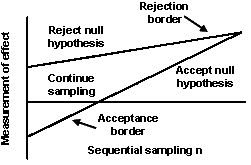

Two-sided SPRT

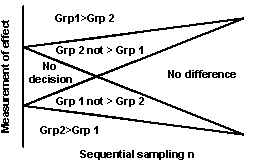

Next we will write python implementation for conditional SPRT


### Write a function to feach data.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import os
import warnings
warnings.filterwarnings('ignore')
sys.path.append("../scripts")
from utils import Utils
from clean_data import DataCleaner

In [6]:
util=Utils()
cleaner=DataCleaner()

In [7]:
df=util.load_data('../data/AdSmartABdata.csv')
df=cleaner.drop_unresponsive(df)

df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1


In [8]:
def transform_data(data):
  '''
  segment data into exposed and control groups
  consider that SmartAd runs the experment hourly, group data into hours. 
      Hint: create new column to hold date+hour and use df.column.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
  create two dataframes with bernouli series 1 for posetive(yes) and 0 for negative(no)
    Hint: Given engagement(sum of yes and no until current observation as an array) and success (yes countas an array), the method generates random binomial distribution
        #Example
           engagement = np.array([5, 3, 3])
           yes = np.array([2, 0, 3])       
         Output is "[1] 1 0 1 0 0 0 0 0 1 1 1", showing a binary array of 5+3+3 values
         of which 2 of the first 5 are ones, 0 of the next 3 are ones, and all 3 of
         the last 3 are ones where position the ones is randomly distributed within each group.
  '''
  # segment data into exposed and control groups
  data_exposed=data[data['experiment']=="exposed"]
  data_control=data[data['experiment']=="control"]

  # group data into hours (date+hour)
  data_exposed=cleaner.convert_to_string(data_exposed,"hour")
  data_control=cleaner.convert_to_string(data_control,"hour")

  data_exposed['date+hour']=pd.to_datetime(data_exposed['date']+" "+data_exposed['hour']+":00:00")
  data_exposed = cleaner.convert_to_datetime(data_exposed,'date+hour')
  data_exposed["date+hour"].map(lambda x : pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))

  data_control['date+hour']=pd.to_datetime(data_control['date']+" "+data_control['hour']+":00:00")
  data_control = cleaner.convert_to_datetime(data_control,'date+hour')
  data_control["date+hour"].map(lambda x : pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))

  #  Generate benouli series
  data_exposed_summary = data_exposed.groupby('date+hour')['yes'].agg(["sum","count"])
  data_exposed_bernouli=util.bernouli_generator(data_exposed_summary["count"],data_exposed_summary["sum"])
  
  data_control_summary = data_control.groupby('date+hour')['yes'].agg(["sum","count"])
  data_control_bernouli=util.bernouli_generator(data_control_summary["count"],data_control_summary["sum"])


  data_stream=(data_control_bernouli,data_exposed_bernouli)

  return data_stream

In [9]:
data_stream=transform_data(df)

In [10]:
#REFERENCE
# A Conditional Sequential Test for the Equality of Two Binomial Proportions
# William Q. Meeker, Jr
# Journal of the Royal Statistical Society. Series C (Applied Statistics)
# Vol. 30, No. 2 (1981), pp. 109-115
class ConditionalSPRT:
  def __init__(self,exposed,control,odd_ratio,alpha=0.05,beta=0.10,stop=None):
    self.x = exposed
    self.y = control
    self.t1 = odd_ratio
    self.alpha = alpha
    self.beta = beta
    self.stop = stop
  def ConditionalSPRT(self,x,y,t1,alpha=0.05,beta=0.10,stop=None):
    """
    #
    # Meeker's SPRT for matched `x` (treatment) and `y` (control), 
    # both indicator responses, likelihood ratio t1, error rates alpha and beta,
    # and (optionally) truncation after trial stop.
    #
    # The return variable contains these elements:
    #(outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)
    # * outcome:   "continue," "reject null," or "accept null".
    # * n: number observation used for the decsion
    # * k:     Index at which the outcome decision was made (or NA)
    # * l:     lower critical point
    # * u:     upper critical point
    # * truncate_decision: The approximate decision made after truncate point
    # * truncated: If the test was truncated, the value of `n.0`; NA otherwise
    # * x1:       Original data `x`, cumulative
    # * r:         Cumulative sum of x+y
    # * stats:     Series of cumulative sums of log probability ratios
    # * limits:    Two rows giving lower and upper critical limits, respectively
    #
    """
    if t1<=1:
        print('warning',"Odd ratio should exceed 1.")
    if (alpha >0.5) | (beta >0.5):
        print('warning',"Unrealistic values of alpha or beta were passed."
                    +" You should have good reason to use large alpha & beta values")
    if stop!=None:
        stop=math.floor(n0)

    def comb(n, k):
        return math.factorial(n) // math.factorial(k) // math.factorial(n - k)

    def lchoose(b, j):
        a=[]
        if (type(j) is list) | (isinstance(j,np.ndarray)==True):
            if len(j)<2:
                j=j[0]
        if (type(j) is list) | (isinstance(j,np.ndarray)==True):
            for k in j:
                n=b
                if (0 <= k) & (k<= n):
                    a.append(math.log(comb(n,k)))
                else:
                    a.append(0)
        else:
            n=b
            k=j
            if (0 <= k) & (k<= n):
                a.append(math.log(comb(n,k)))
            else:
                a.append(0)

        return np.array(a)

    def g(x,r,n,t1,t0=1):
        """
        #
        # Meeker's (1981) function `g`, the log probability ratio.
        # 
        """
        return -math.log(h(x,r,n,t1))+math.log(h(x,r,n,t0))

    def h(x,r,n,t=1):
        """
        #
        # Reciprocal of Meeker's (1981) function `h`: the conditional probability of 
        # `x` given `r` and `n`, when the odds ratio is `t`.
        #
        # `x` is his "x1", the number of positives in `n` control trials.
        # `r` is the total number of positives.
        # `n` is the number of (control, treatment) pairs.
        # `t` is the odds ratio.
        #
        """
        return f(r,n,t,offset=ftermlog(x,r,n,t))

    def f(r,n,t,offset=0):
        """#
        # Meeker's (1981) function exp(F(r,n,t)), proportional to the probability of 
        #  `r` (=x1+x2) in `n` paired trials with an odds ratio of `t`.
        #
        # This function does *not* vectorize over its arguments.
        #"""
        upper=max(0,r-n)
        lower=min(n,r)
        rng=list(range(upper,lower+1))
        return np.sum(fterm(rng,r,n,t,offset))

    def fterm(j,r,n,t,offset=0):
        ftlog=ftermlog(j,r,n,t,offset)
        return np.array([math.exp(ex) for ex in ftlog])

    def ftermlog(j,r,n,t,offset=0):
        """
        #
        # Up to an additive constant, the log probability that (x1, x1+x2) = (j, r) 
        # in `n` paired trials with odds ratio of `t`.
        #
        # `offset` is used to adjust the result to avoid under/overflow.
        #
        """
        xx=r-j
        lch=lchoose(n,j)
        lchdiff=lchoose(n,xx)
        lg=np.array(j)*math.log(t)
        lgsum=lch+lchdiff
        lgsum2=lgsum+lg
        lgdiff=lgsum2-offset

        return lgdiff

    def logf(r,n,t,offset=0):
        """
        #
        # A protected vesion of log(f), Meeker's function `F`.
        #
        """
        z=f(r,n,t,offset)
        if z>0:
            return math.log(z)
        else:
            return np.nan

    def clowerUpper(r,n,t1c,t0=1,alpha=0.05,beta=0.10):
        """
        #
        # Meeker's (1981) functions c_L(r,n) and c_U(r,n), the  critical values for x1.
        # 0 <= r <= 2n; t1 >= t0 > 0.
        #
        """
        offset=ftermlog(math.ceil(r/2),r,n,t1c)
        z=logf(r,n,t1c,logf(r,n,t0,offset)+offset)
        a=-math.log(alpha/(1-beta))
        b=math.log(beta/(1-alpha))
        lower=b
        upper=1+a
        return (np.array([lower,upper])+z)/math.log(t1c/t0)

    l=math.log(beta/(1-alpha))
    u=-math.log(alpha/(1-beta))
    sample_size=min(len(x),len(y))
    n=np.array(range(1,sample_size+1))

    if stop!=None:
        n=np.array([z for z in n if z<=stop])
    x1=np.cumsum(x[n-1])
    r=x1+np.cumsum(y[n-1])
    stats=np.array(list(map(g,x1, r, n, [t1]*len(x1)))) #recurcively calls g
        #
        # Perform the test by finding the first index, if any, at which `stats`
        # falls outside the open interval (l, u).
        #
    clu=list(map(clowerUpper,r,n,[t1]*len(r),[1]*len(r),[alpha]*len(r), [beta]*len(r)))
    limits=[]
    for v in clu:
        inArray=[]
        for vin in v:
            inArray.append(math.floor(vin))
        limits.append(np.array(inArray))
    limits=np.array(limits)

    k=np.where((stats>=u) | (stats<=l))
    cvalues=stats[k]
    if cvalues.shape[0]<1:
        k= np.nan
        outcome='Unable to conclude.Needs more sample.'
    else:
        k=np.min(k)
        if stats[k]>=u:
            outcome=f'Exposed group produced a statistically significant increase.'
        else:
            outcome='Their is no statistically significant difference between two test groups'
    if (stop!=None) & (k==np.nan):
        #
        # Truncate at trial stop, using Meeker's H0-conservative formula (2.2).
        # Leave k=NA to indicate the decision was made due to truncation.
        #
        c1=clowerUpper(r,stop,t1,alpha,beta)
        c1=math.floor(np.mean(c1)-0.5)
        if x1[n0]<=c1:
            truncate_decision='h0'
            outcome='Maximum Limit Decision. The aproximate decision point shows their is no statistically significant difference between two test groups'
        else:
            truncate_decision='h1'
            outcome=f'Maximum Limit Decision. The aproximate decision point shows exposed group produced a statistically significant increase.'
        truncated=stop
    else:
        truncate_decision='Non'
        truncated=np.nan
    return (outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)

In [11]:
# Compute Conditional SPRT
odd_ratio =1.01
control = np.array(data_stream[0])
exposed = np.array(data_stream[1])

conditional_sprt = ConditionalSPRT(exposed=exposed,control=control,odd_ratio=odd_ratio)
result = conditional_sprt.ConditionalSPRT(x=conditional_sprt.x,y=conditional_sprt.y,t1=conditional_sprt.t1)

### According to our method, ***result*** is a [1 x 10] object which has the following properties (elements)
result = (outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits)[1*10] <br><br>
[0] outcome:   "continue," "reject null," or "accept null". <br><br>
[1] n: number observation used for the decsion <br><br>
[2] k:     Index at which the outcome decision was made (or NA) <br><br>
[3] l:     lower critical point <br><br>
[4] u:     upper critical point <br><br>
[5] truncate_decision: The approximate decision made after truncate point <br><br>
[6] truncated: If the test was truncated, the value of `n.0`; NA otherwise <br><br>
[7] x1:       Original data `x`, cumulative <br><br>
[8] r:         Cumulative sum of x+y <br><br>
[9] stats:     Series of cumulative sums of log probability ratios <br><br>
[10] limits:    Two rows giving lower and upper critical limits, respectively <br><br>

In [12]:
result[0]

'Unable to conclude.Needs more sample.'

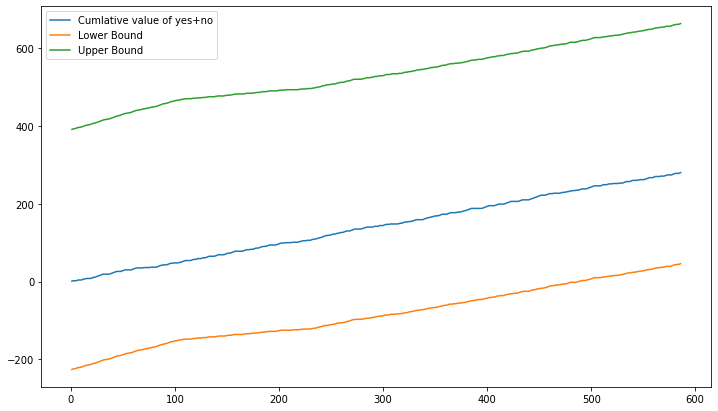

In [14]:
# plot the result

outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits = result
lower = limits[:, 0]
upper = limits[:,1]

fig, ax = plt.subplots(figsize=(12,7))

ax.plot(n, x1, label='Cumlative value of yes+no')

ax.plot(n, lower, label='Lower Bound')
ax.plot(n, upper, label='Upper Bound')

plt.legend()


plt.show()

We can't stop the test at this point we have to proceed until our cumlative value intercepts with either of the bounds